In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
from spaceoracle.tools.network import get_mouse_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels

import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
adata = sc.read_h5ad('/Users/koush/Downloads/slideTCR_asthma_lymphnode_tangramAnno_wTCR_wRegion_sample1.h5ad')

In [169]:
adata.var_names = adata.var_names.str.capitalize()

In [173]:
adata = adata[:, ~adata.var_names.str.contains('Rik')]
adata = adata[:, ~adata.var_names.str.contains('rik')]
adata = adata[:, ~adata.var_names.str.contains(r'^Hb\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('Hp')]
adata = adata[:, ~adata.var_names.str.startswith('Rp')]
adata = adata[:, ~adata.var_names.str.startswith('n-r5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-r5')]
adata = adata[:, ~adata.var_names.str.startswith('N-r5s')]
adata = adata[:, ~adata.var_names.str.startswith('N-r5')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5')]
adata = adata[:, ~adata.var_names.str.startswith('N-R5s')]
adata = adata[:, ~adata.var_names.str.startswith('N-R5')]
adata = adata[:, ~adata.var_names.str.startswith('Aa')]
adata = adata[:, ~adata.var_names.str.startswith('Ab')]
adata = adata[:, ~adata.var_names.str.startswith('Ac')]
adata = adata[:, ~adata.var_names.str.startswith('Gm')]
adata = adata[:, ~adata.var_names.str.startswith('Mir')]
adata = adata[:, adata.var.index.str.len() > 1]
adata = adata[:, [i for i in adata.var_names if not (i[:2].isupper() and i[:2].isalpha())]]
adata = adata[:, [gene for gene in adata.var_names if not gene[-4:].isdigit()]]

In [175]:
adata.var_names_make_unique()
adata.var["Mt"] = adata.var_names.str.startswith("Mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["Mt"], inplace=True)
adata = adata[adata.obs["pct_counts_Mt"] < 20].copy()
adata = adata[:, ~adata.var["Mt"]]
# adata = adata[:, ~adata.var_names.isin(housekeeping_db['Gene'].unique())]
adata.layers["raw_count"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [176]:
adata = adata[adata.obs.celltype_label_tangram!='Unknown']

In [177]:
adata.obs.celltype_label_tangram = adata.obs.celltype_label_tangram.astype(str)

In [178]:
adata.obs.celltype_label_tangram[~adata.obs.celltype_label_tangram.str.contains(' | ')].value_counts()

celltype_label_tangram
B       12312
Tfh       337
Treg      272
DC        227
Th2        85
NK          6
Name: count, dtype: int64

In [179]:
adata = adata[adata.obs.celltype_label_tangram.value_counts()[adata.obs.celltype_label_tangram].values > 100]

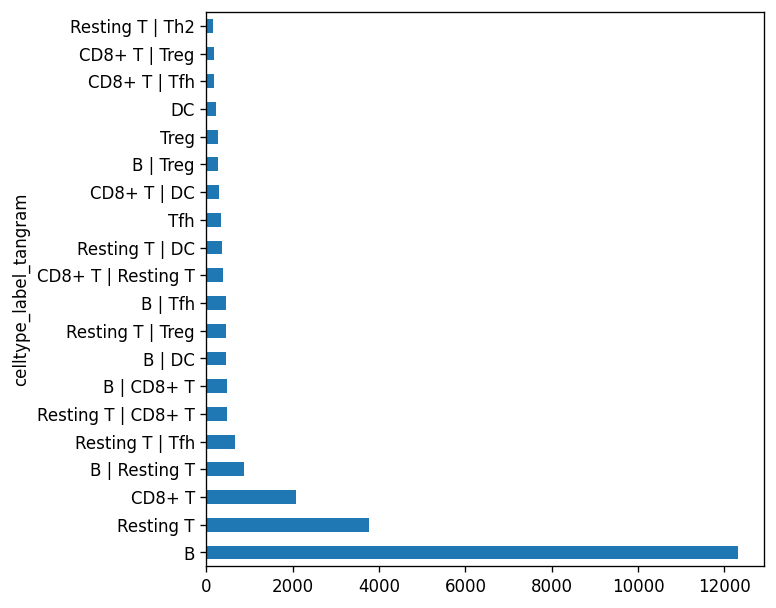

In [180]:
adata.obs.celltype_label_tangram.value_counts().plot(kind='barh')
plt.show()

In [181]:
len(adata.obs.celltype_label_tangram.unique())

20

In [182]:
adata

View of AnnData object with n_obs × n_vars = 24617 × 15296
    obs: 'n_counts', 'n_features', 'uniform_density', 'rna_count_based_density', 'celltype_label_tangram', 'has_tcr', 'has_TRA', 'has_TRB', 'aaSeqCDR3_A', 'aaSeqCDR3_B', 'TRA_clonotype', 'TRB_clonotype', 'final_region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mt', 'log1p_total_counts_Mt', 'pct_counts_Mt'
    var: 'n_cells', 'sparsity', 'Mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'final_region_colors', 'overlap_genes', 'training_genes', 'log1p'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count'

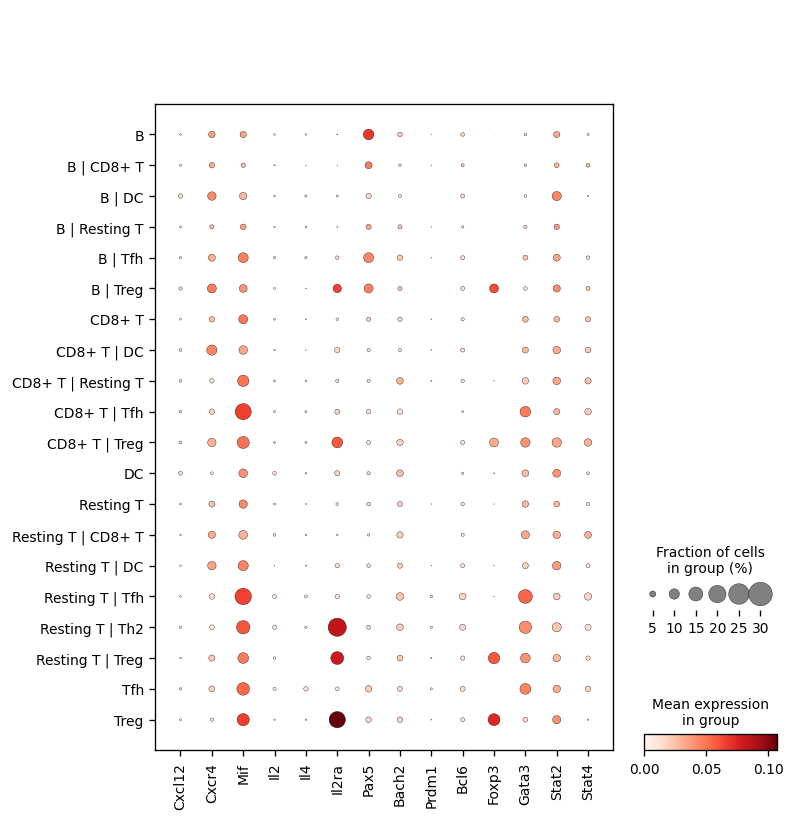

In [184]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['figure.dpi'] = 120
sc.pl.dotplot(
    adata, groupby='celltype_label_tangram', var_names=['Cxcl12','Cxcr4', 'Mif', 'Il2', 'Il4', 
        'Il2ra', 'Pax5', 'Bach2', 'Prdm1', 
        'Bcl6', 'Foxp3', 'Gata3', 'Stat2', 'Stat4']
)

In [185]:
base_GRN = co.data.load_mouse_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [186]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type=None
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

In [4]:
from collections import Counter

In [187]:
housekeeping_db = get_mouse_housekeeping_genes()

In [188]:
adata = adata[:, ~adata.var_names.isin(housekeeping_db['Gene'].unique())]

In [189]:
adata.layers["normalized_count"] = adata.to_df().values.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3500)
adata.X = adata.layers["raw_count"].copy()
adata

AnnData object with n_obs × n_vars = 24617 × 12172
    obs: 'n_counts', 'n_features', 'uniform_density', 'rna_count_based_density', 'celltype_label_tangram', 'has_tcr', 'has_TRA', 'has_TRB', 'aaSeqCDR3_A', 'aaSeqCDR3_B', 'TRA_clonotype', 'TRB_clonotype', 'final_region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mt', 'log1p_total_counts_Mt', 'pct_counts_Mt'
    var: 'n_cells', 'sparsity', 'Mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'final_region_colors', 'overlap_genes', 'training_genes', 'log1p', 'hvg'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count'

In [190]:
sc.pp.filter_genes(adata, min_counts=1)

In [191]:
adata

AnnData object with n_obs × n_vars = 24617 × 11981
    obs: 'n_counts', 'n_features', 'uniform_density', 'rna_count_based_density', 'celltype_label_tangram', 'has_tcr', 'has_TRA', 'has_TRB', 'aaSeqCDR3_A', 'aaSeqCDR3_B', 'TRA_clonotype', 'TRB_clonotype', 'final_region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mt', 'log1p_total_counts_Mt', 'pct_counts_Mt'
    var: 'n_cells', 'sparsity', 'Mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts'
    uns: 'final_region_colors', 'overlap_genes', 'training_genes', 'log1p', 'hvg'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count'

In [192]:
ligand_receptor_genes = np.intersect1d(
    adata.var_names, 
    df_ligrec.ligand.unique().tolist()+df_ligrec.receptor.unique().tolist())

In [195]:
adata.obs['cell_type'] = adata.obs['celltype_label_tangram'].copy()

In [196]:
lr_df = adata.to_df(layer='normalized_count').join(
    adata.obs.cell_type).groupby('cell_type').mean()[
        ligand_receptor_genes].mean().sort_values(ascending=False).to_frame().reset_index()
lr_df.columns = ['genes', 'expr']

In [197]:
lr_df['mean_expr'] = lr_df['genes'].apply(lambda x: adata.to_df(layer='normalized_count')[x].mean())

In [198]:
adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(
    [
        'Cxcl12','Cxcr4', 'Mif', 'Il2', 'Il4', 
        'Il2ra', 'Pax5', 'Bach2', 'Prdm1', 
        'Bcl6', 'Foxp3', 'Gata3', 'Stat2', 'Stat4'
    ] + lr_df.query('expr > 0.005').genes.to_list()
))]


In [199]:
adata

View of AnnData object with n_obs × n_vars = 24617 × 3604
    obs: 'n_counts', 'n_features', 'uniform_density', 'rna_count_based_density', 'celltype_label_tangram', 'has_tcr', 'has_TRA', 'has_TRB', 'aaSeqCDR3_A', 'aaSeqCDR3_B', 'TRA_clonotype', 'TRB_clonotype', 'final_region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mt', 'log1p_total_counts_Mt', 'pct_counts_Mt', 'cell_type'
    var: 'n_cells', 'sparsity', 'Mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts'
    uns: 'final_region_colors', 'overlap_genes', 'training_genes', 'log1p', 'hvg'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count'

In [19]:
%matplotlib inline

In [200]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [205]:
adata.obs = adata.obs[['cell_type', 'cell_type_int']]

In [207]:
del adata.uns

In [212]:
adata.var = adata.var.drop(columns=adata.var.columns, inplace=False)

In [5]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')

In [213]:
adata

AnnData object with n_obs × n_vars = 24617 × 3604
    obs: 'cell_type', 'cell_type_int'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count'

In [6]:
adata

AnnData object with n_obs × n_vars = 24617 × 3604
    obs: 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
pcs = BaseTravLR.perform_PCA(adata)
# BaseTravLR.knn_imputation(adata, pcs, method='MAGIC')

In [8]:
BaseTravLR.knn_imputation(adata, pcs, method='MAGIC')

Calculating MAGIC...
  Running MAGIC on 24617 cells and 3604 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.45 seconds.
    Calculating KNN search...
    Calculated KNN search in 38.36 seconds.
    Calculating affinities...
    Calculated affinities in 37.71 seconds.
  Calculated graph and diffusion operator in 85.55 seconds.
  Calculating imputation...
  Calculated imputation in 2.67 seconds.
Calculated MAGIC in 88.27 seconds.


In [13]:
# %matplotlib inline
# sc.pl.dotplot(
#     adata, 
#     ['Cxcl12','Cxcr4', 'Stat2', 'Stat4','Prdm1', 'Il2', 'Il4', 
#      'Il2ra', 'Pax5', 'Bach2', 'Bcl6', 'Foxp3'], groupby='cell_type', 
#     expression_cutoff=0.0,
#     layer='imputed_count')
# plt.show()

In [14]:
adata.write_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')